In [2]:
%load_ext autoreload
%autoreload 2

In [33]:
import os
import json
from glob import glob
from collections import namedtuple

import torch
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from bbb.utils.pytorch_setup import DEVICE
from bbb.utils.plotting import plot_weight_samples
from bbb.config.constants import KL_REWEIGHTING_TYPES, PRIOR_TYPES, VP_VARIANCE_TYPES
from bbb.config.parameters import Parameters, PriorParameters
from bbb.models.dnn import ClassificationDNN
from bbb.models.bnn import ClassificationBNN
from bbb.data import load_mnist
from bbb.models.layers import BaseBFC

from labellines import labelLines

In [4]:
matplotlib.style.use('default')
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize': 'medium'})
colors_hex = {'blue': '#1F77B4', 'orange': '#FF7F0E', 'green': '#2CA02C'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

## Helper Classes

In [5]:
# ModelDetails = namedtuple('ModelDetails', 'dir mclass')
ModelDetails = namedtuple('ModelDetails', 'dir mclass description')

## Trained Classification Models

In [6]:
MODEL_DETAILS_DICT = {
    # BNN - Singe Gaussian Prior
    "bnn_sgp_1200": ModelDetails("../saved_models/BBB_classification/baseline/single_gaussian_prior/1200/2022-03-15-09.18.07", ClassificationBNN, "BNN - 1200 hidden units, SGP"),
    "bnn_sgp_800": ModelDetails("../saved_models/BBB_classification/baseline/single_gaussian_prior/800/2022-03-15-14.25.46", ClassificationBNN, "BNN - 800 hidden units, SGP"),
    "bnn_sgp_400": ModelDetails("../saved_models/BBB_classification/baseline/single_gaussian_prior/400/2022-03-15-14.26.34", ClassificationBNN, 
    "BNN - 400 hidden units, SGP"),

    # BNN - MoG
    "bnn_mog_1200": ModelDetails("../saved_models/BBB_classification/baseline/mog_prior/sigma_1_1_sigma_2_exp_7/1200/2022-03-27-07.54.00", ClassificationBNN, "BNN - 1200 hidden units, MoG"),
    "bnn_mog_800": ModelDetails("../saved_models/BBB_classification/baseline/mog_prior/sigma_1_1_sigma_2_exp_7/800/2022-03-27-10.10.21", ClassificationBNN, "BNN - 800 hidden units, MoG"),
    "bnn_mog_400": ModelDetails("../saved_models/BBB_classification/baseline/mog_prior/sigma_1_1_sigma_2_exp_7/400/2022-03-27-07.55.07", ClassificationBNN, 
    "BNN - 400 hidden units, MoG"),

    # DNN - no dropout
    "dnn_1200": ModelDetails("../saved_models/DNN_classification/baseline/1200/2022-03-15-14.28.25", ClassificationDNN, "DNN - 1200 hidden units"),
    "dnn_800": ModelDetails("../saved_models/DNN_classification/baseline/800/2022-03-15-16.06.09", ClassificationDNN, "DNN - 800 hidden units"),
    "dnn_400": ModelDetails("../saved_models/DNN_classification/baseline/400/2022-03-15-16.10.34", ClassificationDNN, "DNN - 400 hidden units"),
    
    # DNN - dropout
    "dnn_do_400": ModelDetails("../saved_models/DNN_classification/dropout/0.5/1200/2022-03-15-15.21.46", ClassificationDNN, "Dropout - 400 hidden units, 0.5 dropout"),
    "dnn_do_800": ModelDetails("../saved_models/DNN_classification/dropout/0.5/800/2022-03-15-15.58.04", ClassificationDNN, "Dropout - 800 hidden units, 0.5 dropout"),
    "dnn_do_1200": ModelDetails("../saved_models/DNN_classification/dropout/0.5/400/2022-03-15-16.26.18", ClassificationDNN, "Dropout - 1200 hidden units, 0.5 dropout"),
}

## Set Model

In [8]:
MODEL = "bnn_sgp_1200"
MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]
MODEL_DETAILS

ModelDetails(dir='../saved_models/BBB_classification/baseline/single_gaussian_prior/1200/2022-03-15-09.18.07', mclass=<class 'bbb.models.bnn.ClassificationBNN'>, description='BNN - 1200 hidden units, SGP')

## Load Parameters

In [9]:
with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
    params_dict = json.load(f)

# Need to deserialise the prior_params into a PriorParameters object
if params_dict['prior_params']:
    params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

params = Parameters(**params_dict)
params

Parameters(name='BBB_classification', input_dim=784, output_dim=10, batch_size=128, epochs=300, hidden_units=1200, hidden_layers=3, lr=0.0001, step_size=75, opt_choice='Adam', gamma=0.1, weight_mu_range=[-0.2, 0.2], weight_rho_range=[-5, -4], prior_params=PriorParameters(w_sigma=1.0, b_sigma=1.0, w_sigma_2=0.2, b_sigma_2=0.2, w_mixture_weight=0.5, b_mixture_weight=0.5), elbo_samples=2, inference_samples=10, regression_likelihood_noise=None, kl_reweighting_type=1, vp_variance_type=1, prior_type=0, local_reparam_trick=False, dropout=False, dropout_p=None, early_stopping=False, early_stopping_thresh=0, model_save_basedir='./saved_models', tensorboard_save_dir='./tensorboard')

## Load Data

In [10]:
X_val = load_mnist(train=False, batch_size=params.batch_size, shuffle=True)

/Users/maxbronckers/Downloads/BBB/env/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Load Model

In [11]:
# net = MODEL_DETAILS.mclass(params=params, eval_mode=True).to(DEVICE)
net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device('cpu')))

2022-03-27 18:28:09,517 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 18:28:09,518 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 18:28:09,529 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 18:28:09,529 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 18:28:09,531 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 18:28:09,531 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


<All keys matched successfully>

## Evaluate

In [11]:
def evaluate_classifier(net, X_val):
    correct = 0
    total = 0

    # Logging
    dict = {}
    dict['labels'] = []
    dict['probs'] = {}
    dict['preds'] = {}
    dict['preds']['incorrect'] = []
    dict['preds']['correct'] = []
    dict['preds']['all'] = []

    dict['probs']['all'] = []
    dict['probs']['max'] = []

    dict['probs']['incorrect'] = {}
    dict['probs']['correct'] = {}
    dict['probs']['incorrect']['all'] = []
    dict['probs']['correct']['all'] = []
    dict['probs']['incorrect']['max'] = []
    dict['probs']['correct']['max'] = []

    # Eval & save results appropriately
    with torch.no_grad():
        for inputs, labels in X_val:
            # inputs = inputs.to(DEVICE)
            # labels = labels.to(DEVICE)
            
            preds, probs = net.predict(inputs)

            total += net.batch_size
            correct += (labels == preds).sum()

            # create two arrays;
            preds = preds.cpu().detach().numpy()
            probs = probs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()

            correct_filter = np.where(labels == preds)
            incorrect_filter = np.where(labels != preds)

            correct_preds = preds[correct_filter]
            correct_probs = probs[correct_filter]
            
            incorrect_preds = preds[incorrect_filter]
            incorrect_probs = probs[incorrect_filter]


            dict['labels'].extend(labels)
            dict['probs']['all'].extend(probs) 
            dict['preds']['all'].extend(preds)
            
            dict['probs']['max'].append(np.max(probs, axis=1))
            
            dict['preds']['incorrect'].extend(incorrect_preds)
            dict['preds']['correct'].extend(correct_preds)
            
            dict['probs']['incorrect']['all'].extend(incorrect_probs)
            dict['probs']['correct']['all'].extend(correct_probs)

    eval_score = correct / total

    dict['eval_score'] = eval_score
    return dict
    

In [12]:
net.evaluate(X_val)

tensor(0.9848)

In [11]:
eval_dict = evaluate_classifier(net, X_val)
eval_dict['eval_score']

tensor(0.9845)

### Adversarial Evaluate

In [ ]:
X_adv_0 = load_adverserial_mnist(train=False, size=8*params.batch_size, batch_size=params.batch_size, shuffle=True, randomise=True, epsilon=0)
X_adv_5 = load_adverserial_mnist(train=False, size=8*params.batch_size, batch_size=params.batch_size, shuffle=True, randomise=True, epsilon=0.05)
X_adv_10 = load_adverserial_mnist(train=False, size=8*params.batch_size, batch_size=params.batch_size, shuffle=True, randomise=True, epsilon=0.1)
X_adv_25 = load_adverserial_mnist(train=False, size=8*params.batch_size, batch_size=params.batch_size, shuffle=True, randomise=True, epsilon=0.25)

eval_dict = evaluate_classifier(net, X_adv_0)
eval_dict['eval_score']

eval_dict = evaluate_classifier(net, X_adv_5)
eval_dict['eval_score']

eval_dict = evaluate_classifier(net, X_adv_10)
eval_dict['eval_score']

eval_dict = evaluate_classifier(net, X_adv_25)
eval_dict['eval_score']

## Plot Weights

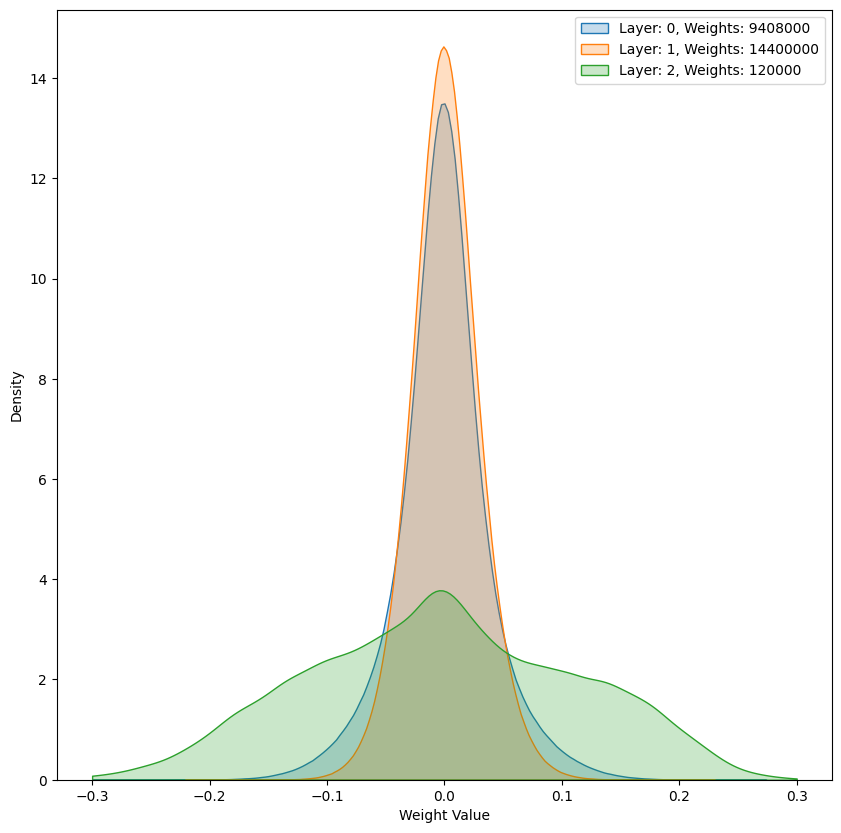

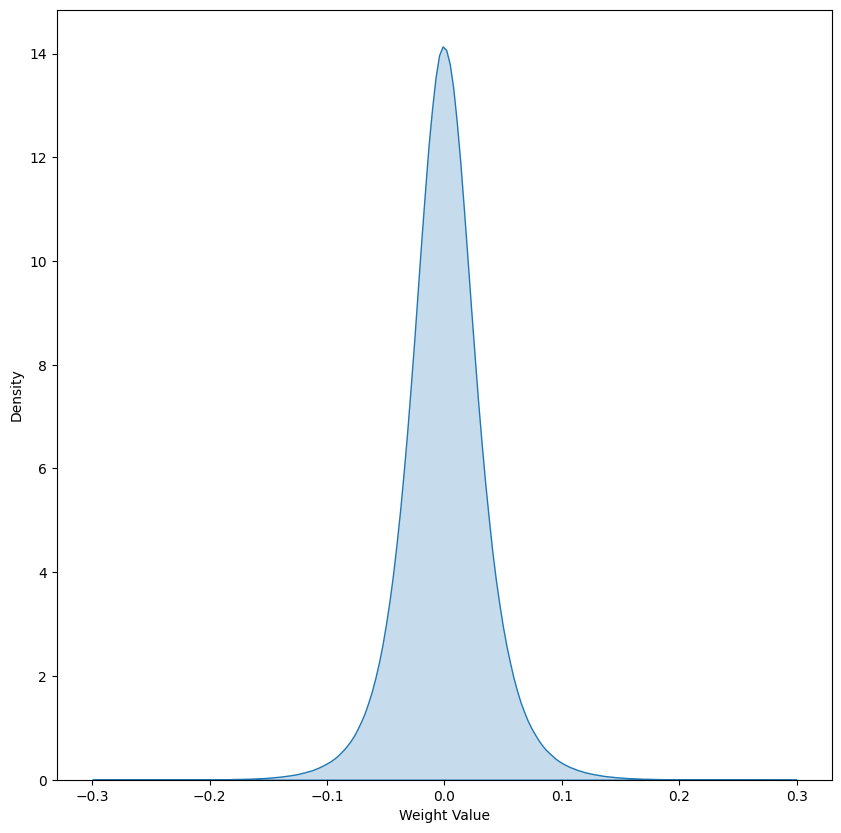

In [12]:
plot_weight_samples(net.weight_samples())

## Remove Weight with Low S/N Ratio

In [57]:
weight_mean_tensors, weight_std_tensors = net.get_weights()
weight_snr_tensors = [10*torch.log10(torch.abs(weight_mean_tensors[i])/weight_std_tensors[i]) for i in range(len(weight_mean_tensors))]

In [58]:
weight_snrs = np.array([])
for i in weight_snr_tensors:
    weight_snrs = np.hstack((weight_snrs, i.flatten().detach().numpy()))

Text(0.5, 1.0, 'Weight Signal-to-Noise Ratio CDF')

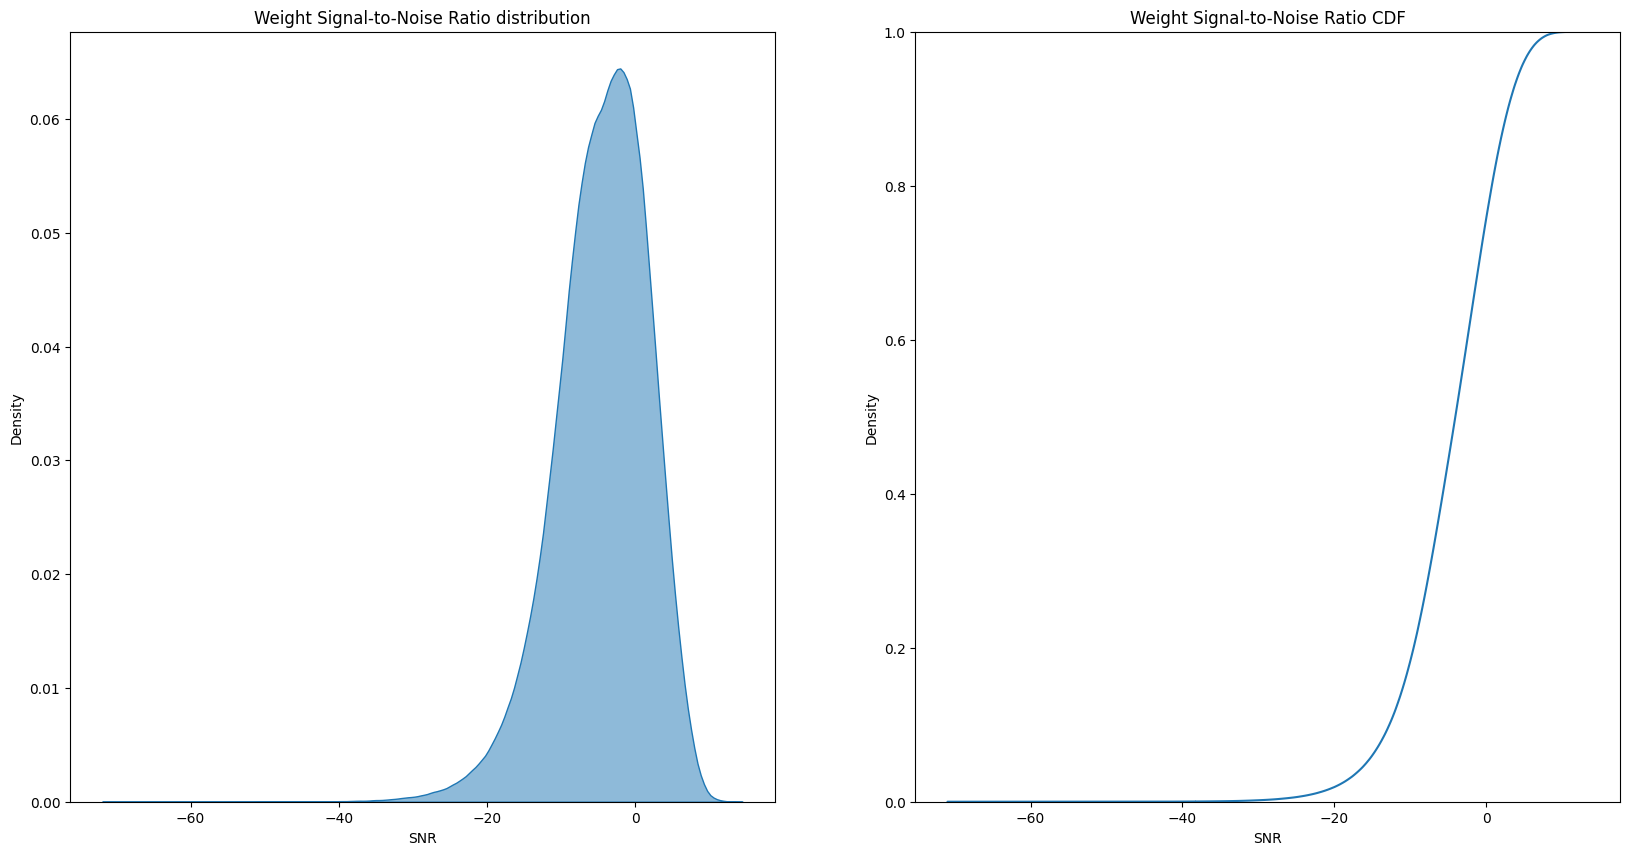

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
# ax.hist(weight_snrs, density=True, bins=50)
ax = axes[0]
ax1 = axes[1]

sns.kdeplot(weight_snrs, fill=True, ax=ax, alpha=0.5)
sns.ecdfplot(weight_snrs, ax=ax1)

# Formatting of plot
ax.set_xlabel('SNR')
ax.set_ylabel('Density')
ax.set_title('Weight Signal-to-Noise Ratio distribution')

ax1.set_xlabel('SNR')
ax1.set_ylabel('Density')
ax1.set_title('Weight Signal-to-Noise Ratio CDF')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# ax.hist(weight_snrs, density=True, bins=50)
sns.ecdfplot(weight_snrs, ax=ax)
ax.set_xlabel('SNR')
ax.set_ylabel('Density')
ax.set_title('Weight Signal-to-Noise Ratio CDF')

In [16]:
acc_dict = {}
for model in MODEL_DETAILS_DICT.keys():
    acc_dict[model] = {}

In [ ]:
import ast
path = '../saved_models/BBB_classification/baseline/pruning_accuracy.txt'
f = open(path)
contents = f.read()
acc_dict = ast.literal_eval(contents)

In [18]:
for MODEL in MODEL_DETAILS_DICT.keys():
    if MODEL.__contains__("bnn"):
        ### Load model
        MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]

        with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
            params_dict = json.load(f)

        # Need to deserialise the prior_params into a PriorParameters object
        if params_dict['prior_params']:
            params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

        params = Parameters(**params_dict)

        net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
        net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device('cpu')))

        ### Get weights & SNRs
        weight_mean_tensors, weight_std_tensors = net.get_weights()
        weight_snr_tensors = [10*torch.log10(torch.abs(weight_mean_tensors[i])/weight_std_tensors[i]) for i in range(len(weight_mean_tensors))]
        weight_snrs = np.array([])
        for i in weight_snr_tensors:
            weight_snrs = np.hstack((weight_snrs, i.flatten().detach().numpy()))

        ### Run Pruning 
        # quantile_thresholds = np.linspace(0,1,20) # 
        quantile_thresholds = [0.0, 0.25, 0.50, 0.75, 0.80, 0.85, 0.90, 0.95, 1.0]
        weight_mean_tensors, weight_std_tensors = net.get_weights()
        weight_snr_tensors = [10*torch.log10(torch.abs(weight_mean_tensors[i])/weight_std_tensors[i]) for i in range(len(weight_mean_tensors))]

        accuracies = []
        prune_ratios = {}
        prune_ratios['1L'] = []
        prune_ratios['2L'] = []
        prune_ratios['3L'] = []

        for snr in quantile_thresholds:
            snr_threshold = np.quantile(weight_snrs, snr)
            weight_fill_masks = [weight_snr_tensors[i] < snr_threshold for i in range(len(weight_snr_tensors))]

            net.prune_weights(weight_fill_masks) # order from 0.05 to 1.0 means that don't have to reset the weights before pruning them (as each threshold is a superset of the last threshold)

            accuracy = net.evaluate(X_val)
            accuracies.append(accuracy)
            
            pruned_weight_samples = net.get_pruned_weight_samples(weight_fill_masks)
            
            # Print pruning ratio per layer
            for i, (x, layer) in enumerate(zip(pruned_weight_samples, [layer for layer in net.model if isinstance(layer, BaseBFC)])):
                num_non_pruned_weights = int(x.size()[0]/net.inference_samples)
                num_weights = layer.dim_in * layer.dim_out
                prune_ratio = 1 - num_non_pruned_weights/num_weights
                prune_ratios[list(prune_ratios.keys())[i]].append(prune_ratio)
            
        acc_dict[MODEL]['accuracies'] = accuracies
        acc_dict[MODEL]['prune_ratios'] = prune_ratios

for model in list(acc_dict.keys()):
    if model.__contains__("dnn"): del acc_dict[model]
    else:
        for idx, a in enumerate(acc_dict[model]['accuracies']):
            acc_dict[model]['accuracies'][idx] = a.item()

2022-03-27 18:36:57,903 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 18:36:57,903 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 18:36:57,913 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 18:36:57,914 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 18:36:57,915 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 18:36:57,915 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 18:43:36,496 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 18:43:36,497 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 18:43:36,502 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 18:43:36,502 - bbb.models.layers - INFO

AttributeError: 'ClassificationDNN' object has no attribute 'get_weights'

In [67]:
acc_dict

{'bnn_sgp_1200': {'accuracies': [tensor(0.9847),
   tensor(0.9839),
   tensor(0.9847),
   tensor(0.9846),
   tensor(0.9828),
   tensor(0.9791),
   tensor(0.9703),
   tensor(0.9259),
   tensor(0.1053)],
  'prune_ratios': {'1L': [0.0,
    0.3169302721088435,
    0.5433237670068027,
    0.7057780612244897,
    0.743326955782313,
    0.785796130952381,
    0.8377455357142858,
    0.9055846088435374,
    1.0],
   '2L': [0.0,
    0.20804374999999997,
    0.4751361111111111,
    0.78365,
    0.8419659722222222,
    0.8969770833333334,
    0.9456451388888889,
    0.9836076388888889,
    1.0],
   '3L': [0.0,
    0.037416666666666654,
    0.08708333333333329,
    0.17900000000000005,
    0.20725000000000005,
    0.2463333333333333,
    0.30333333333333334,
    0.39925,
    0.9999166666666667]}},
 'bnn_sgp_800': {'accuracies': [tensor(0.9834),
   tensor(0.9833),
   tensor(0.9826),
   tensor(0.9631),
   tensor(0.9511),
   tensor(0.9074),
   tensor(0.7740),
   tensor(0.2189),
   tensor(0.0994)],
  

Save distribution of pruned weights across layers

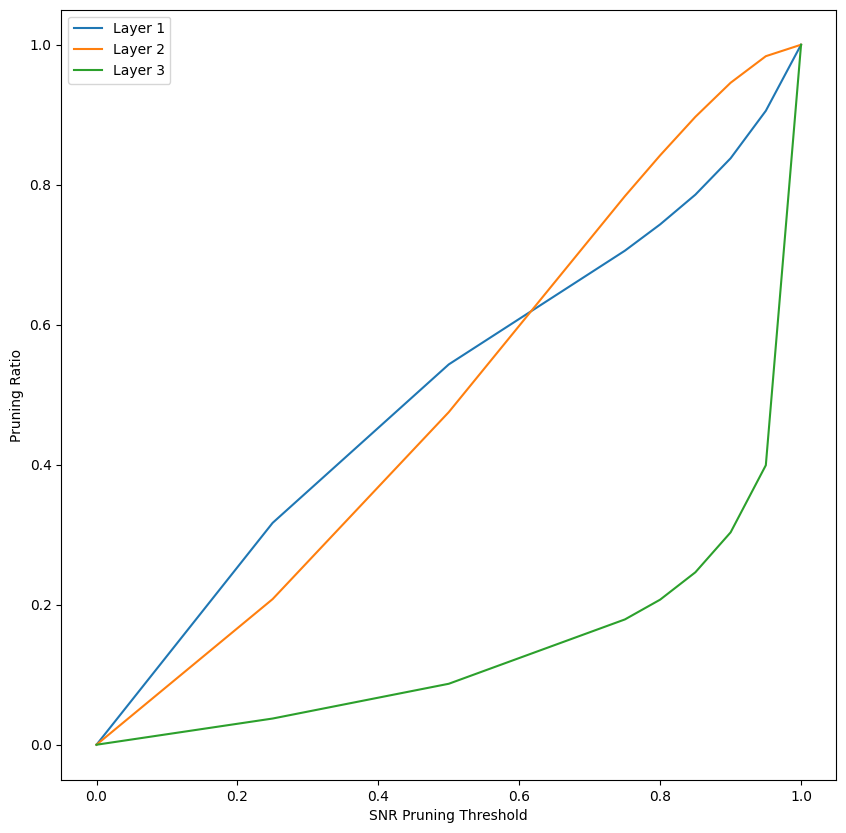

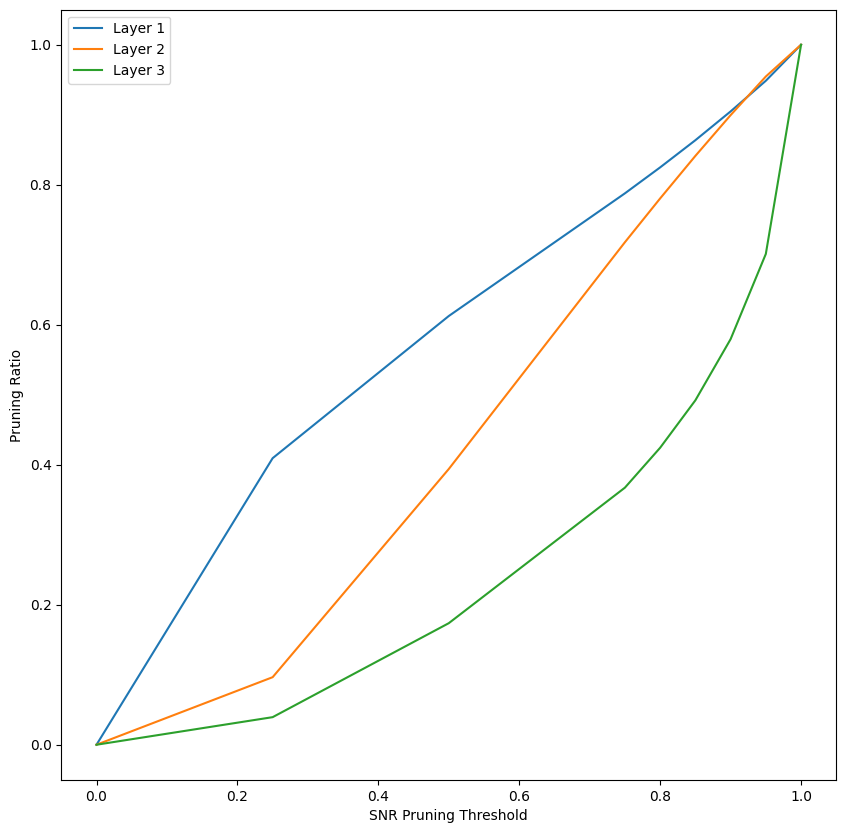

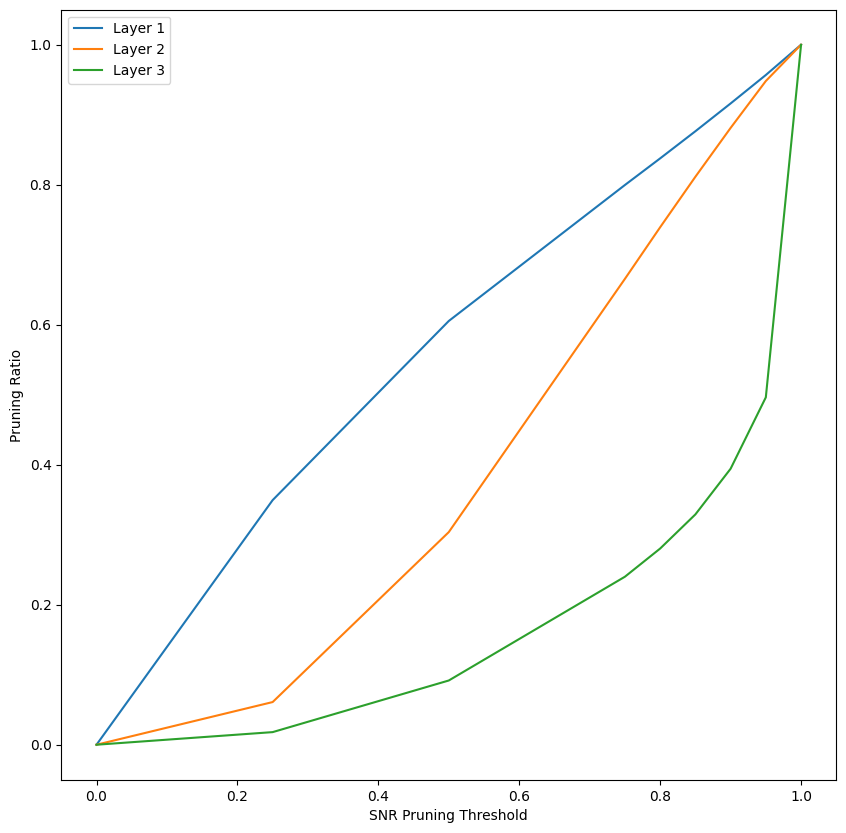

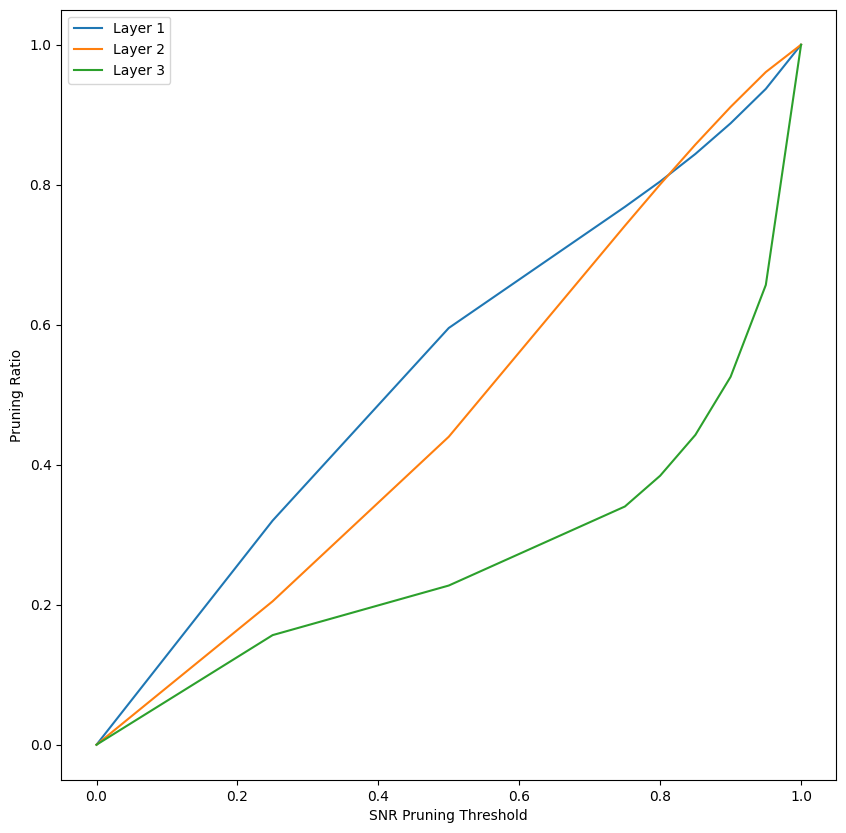

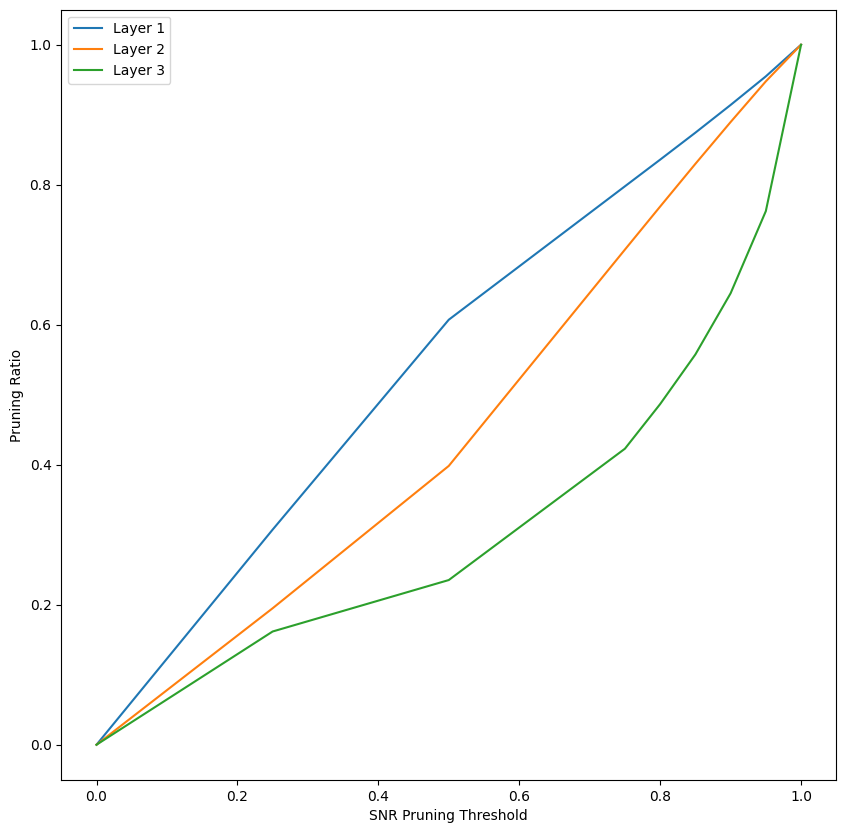

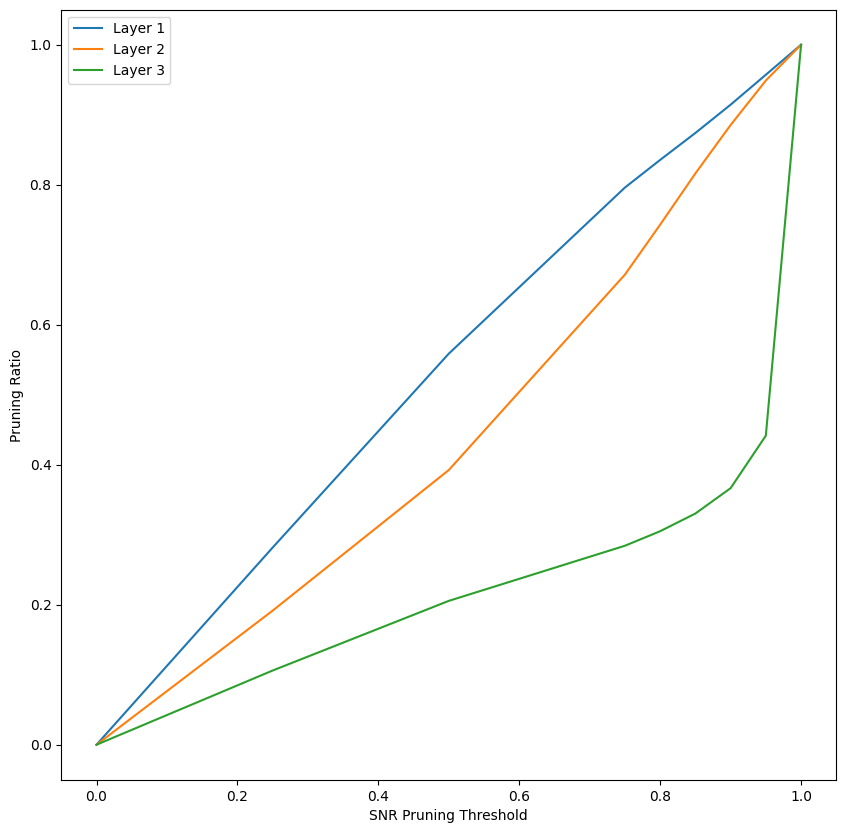

In [65]:
save_dir = "../plots/classification/pruning"
for model in acc_dict.keys():
    if not model.__contains__("bnn"): continue
    description = MODEL_DETAILS_DICT[model].description
    accuracies = acc_dict[model]['accuracies']
    prune_ratios = acc_dict[model]['prune_ratios']

    fig, ax = plt.subplots(1, 1, figsize=(10,10))

    for layer in prune_ratios.keys():
        sns.lineplot(y=prune_ratios[layer], x=quantile_thresholds, label=f"Layer {layer[0]}", ax=ax)

    # Formatting of plot
    ax.set_xlabel('SNR Pruning Threshold')
    ax.set_ylabel('Pruning Ratio')
    # ax.set_title(f'{description} Weight Pruning Distribution')

    plt.savefig(os.path.join(save_dir, f'{model}_pruning_weight_dist.png'), pad_inches=0.2, bbox_inches='tight')

    plt.show()

Plot accuracy vs threshold for all BNN models in one plot

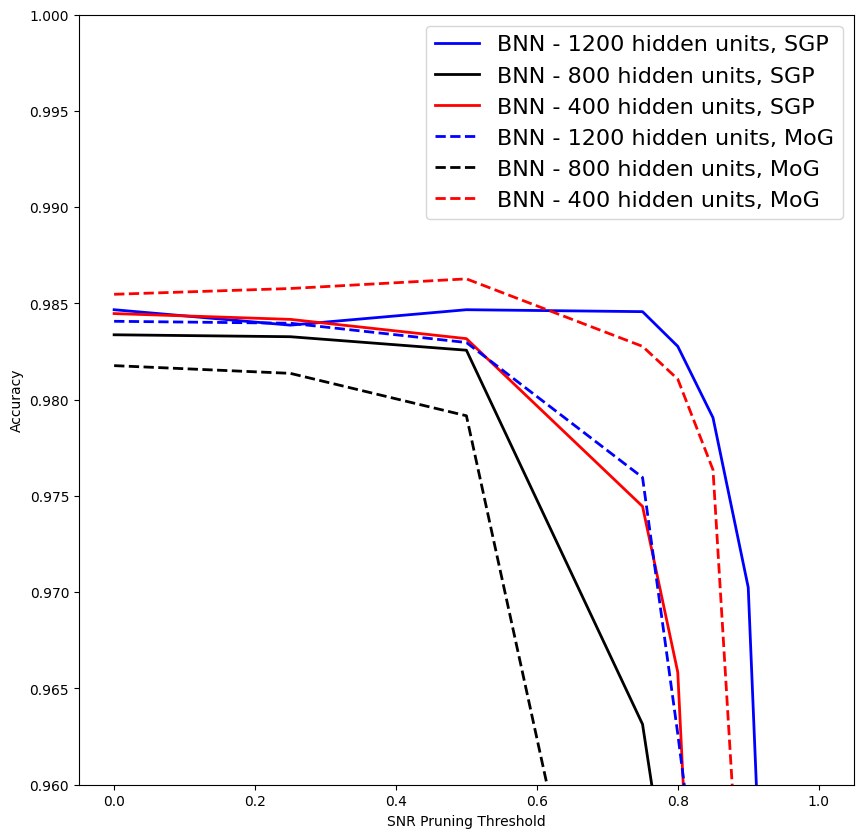

In [66]:
save_dir = "../plots/classification/pruning"
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in acc_dict.keys():
    if not model.__contains__("bnn"): continue
    description = MODEL_DETAILS_DICT[model].description
    accuracies = acc_dict[model]['accuracies']
    prune_ratios = acc_dict[model]['prune_ratios']
    
    lw = 2
    if model.__contains__("1200"):
        color = "b"
    elif model.__contains__("800"):
        color = "black"
    else:
        color = "r"
    
    if model.__contains__("mog"):
        sns.lineplot(y=[float(x.detach().numpy()) for x in accuracies], x=quantile_thresholds, label=f"{description}", ax=ax, color=color,linestyle='--', linewidth=lw)
    else:
        sns.lineplot(y=[float(x.detach().numpy()) for x in accuracies], x=quantile_thresholds, label=f"{description}", ax=ax, color=color,linewidth=lw)


    # Formatting of plot
    ax.set_xlabel('SNR Pruning Threshold')
    ax.set(ylim=(0.96, 1.0))
    ax.set_ylabel('Accuracy')
    # ax.set_title('Pruned BNN Accuracy')
    # labelLines(ax.get_lines()[:-1], zorder=2.5, backgroundcolor="none")


    ax.legend(loc='upper right', prop={'size': 16})
plt.savefig(os.path.join(save_dir, 'accuracy_pruning_plot.png'), pad_inches=0.2, bbox_inches='tight')
plt.show()

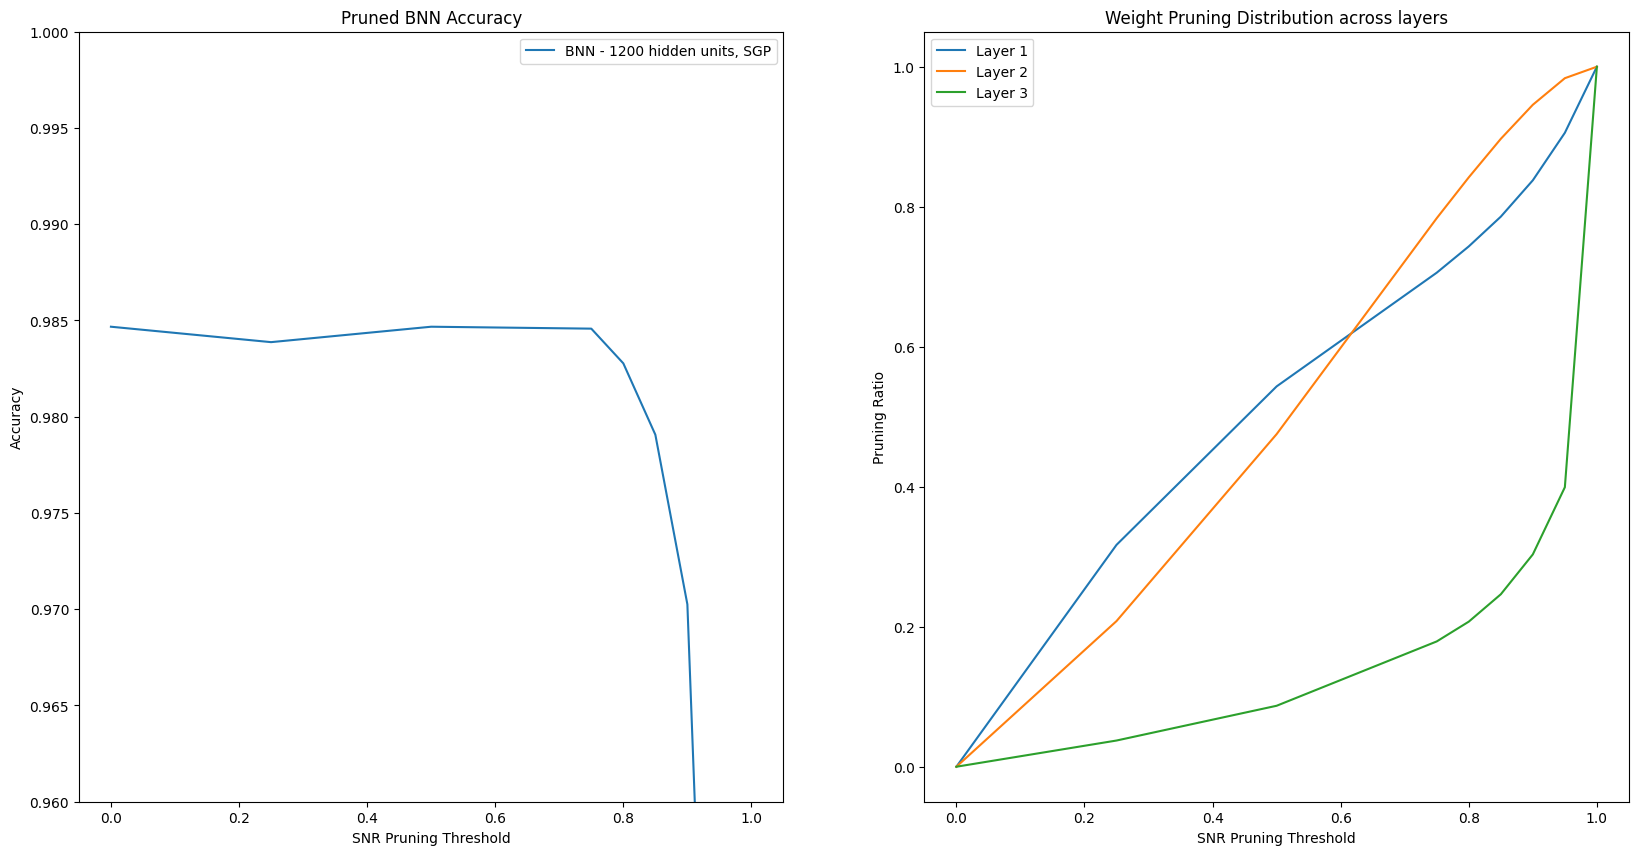

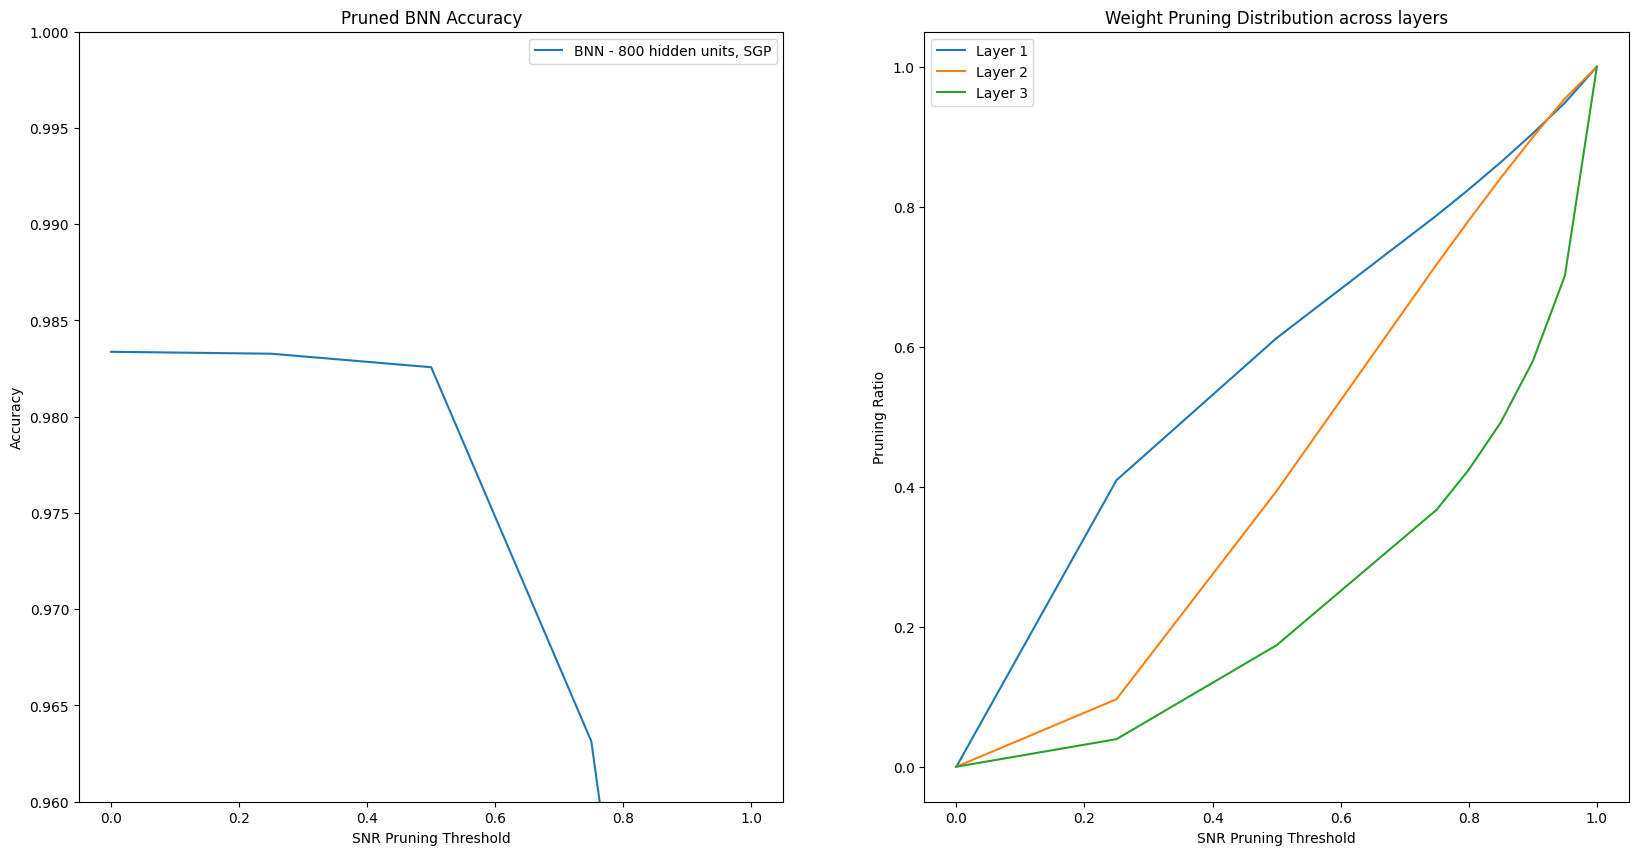

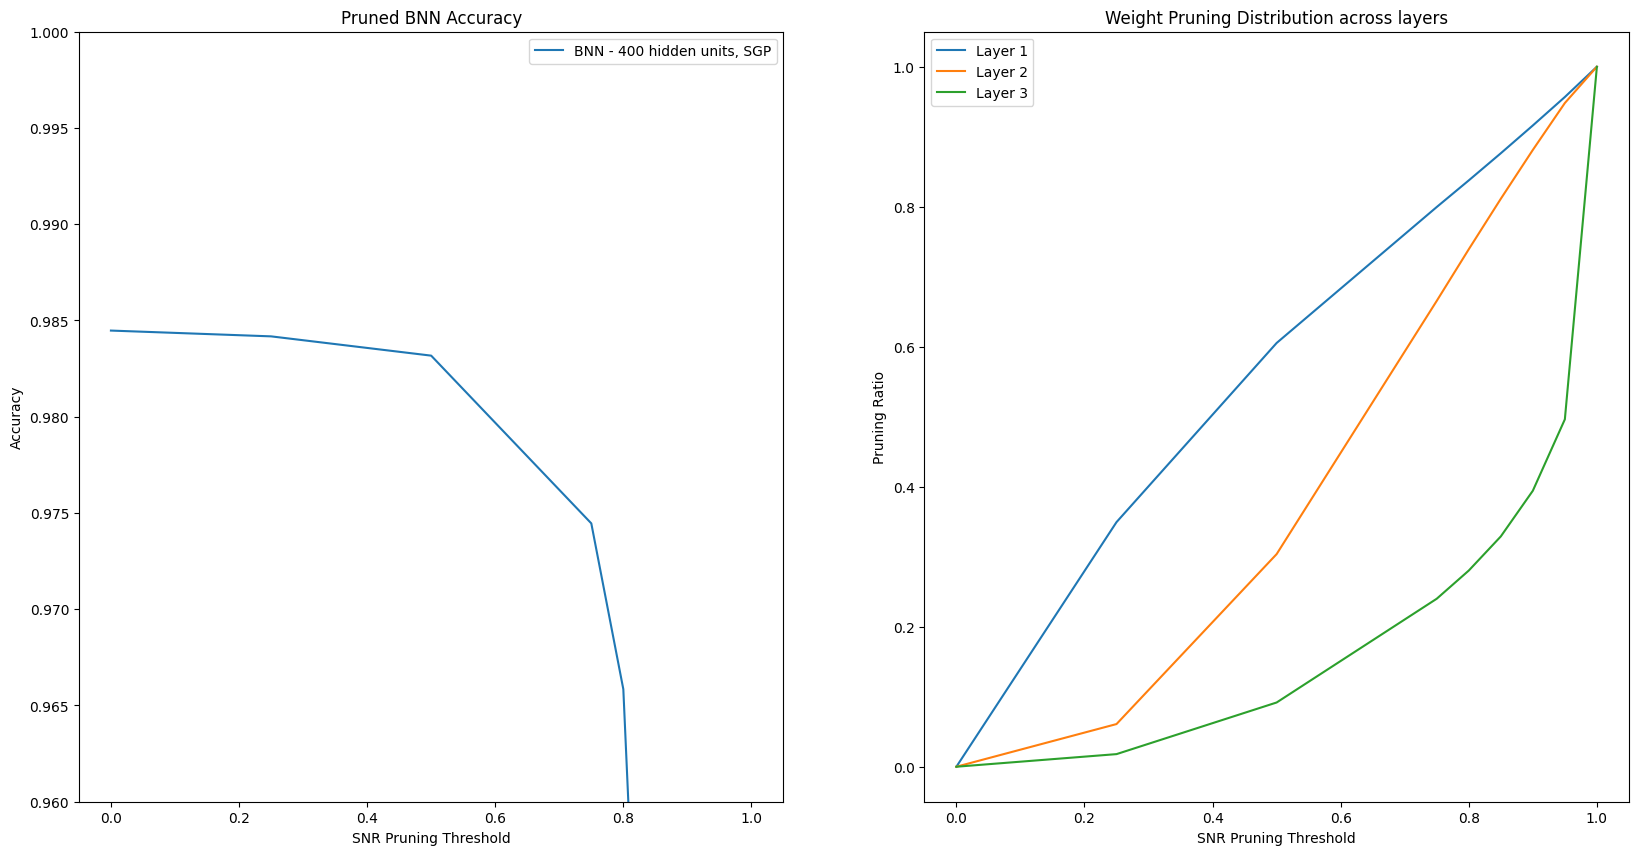

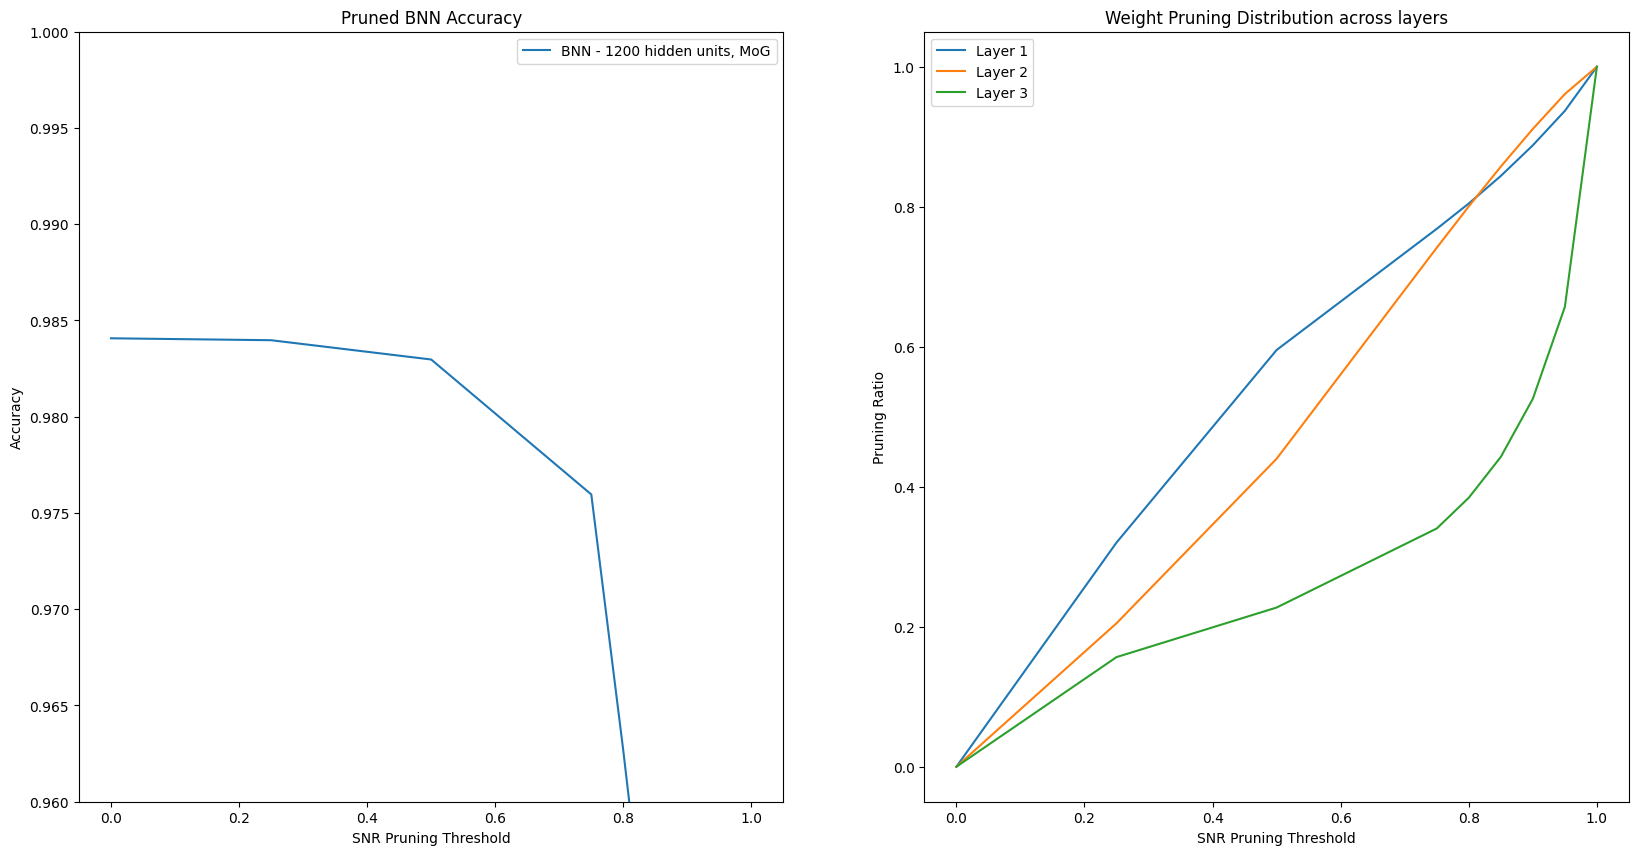

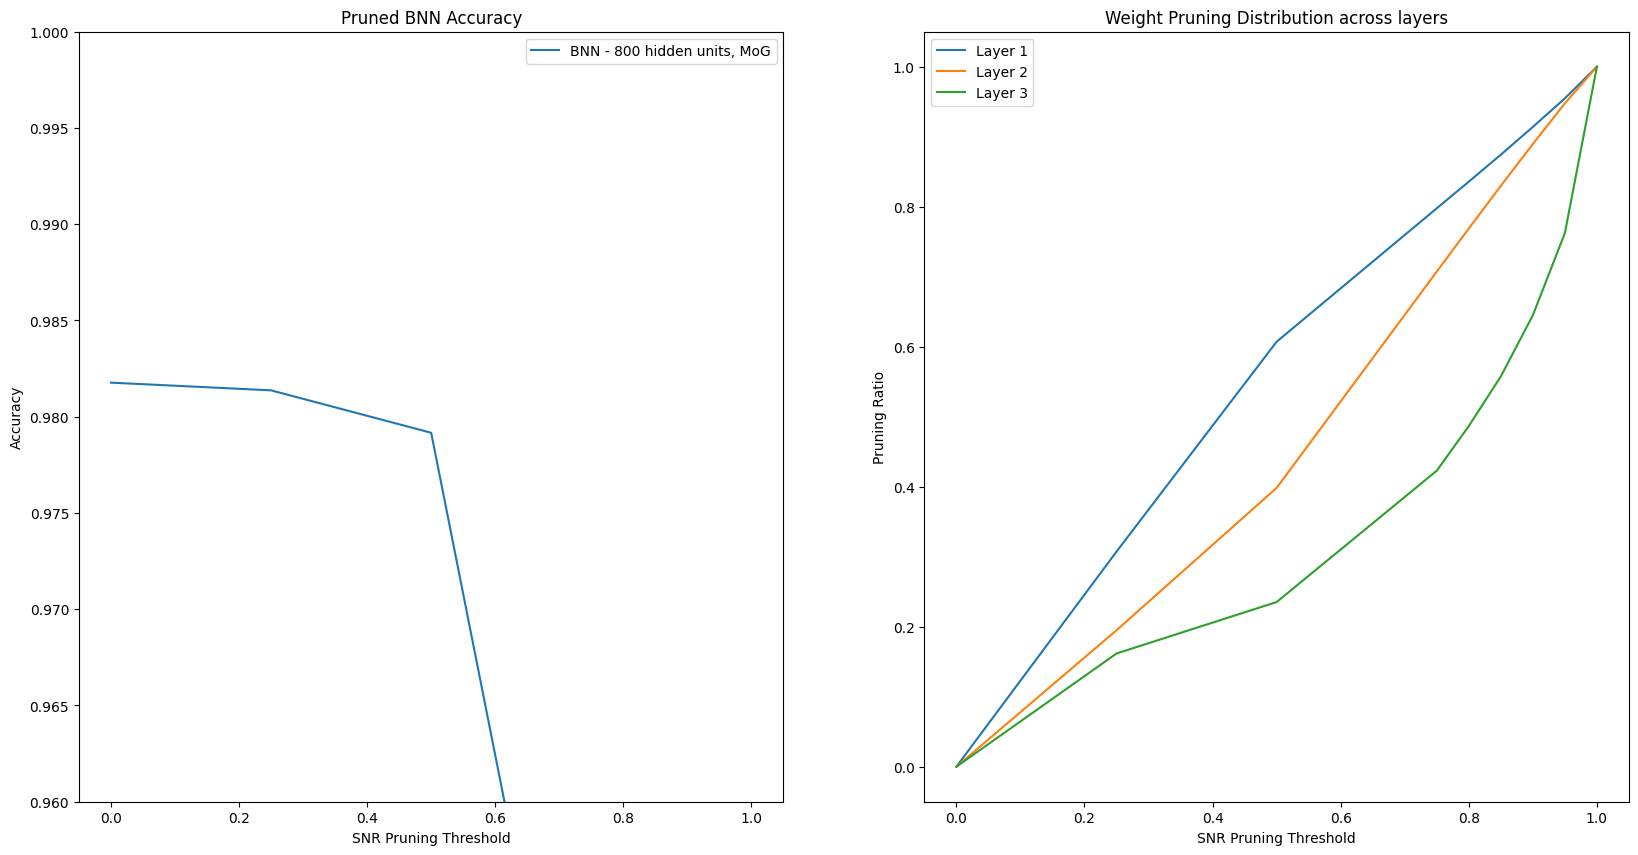

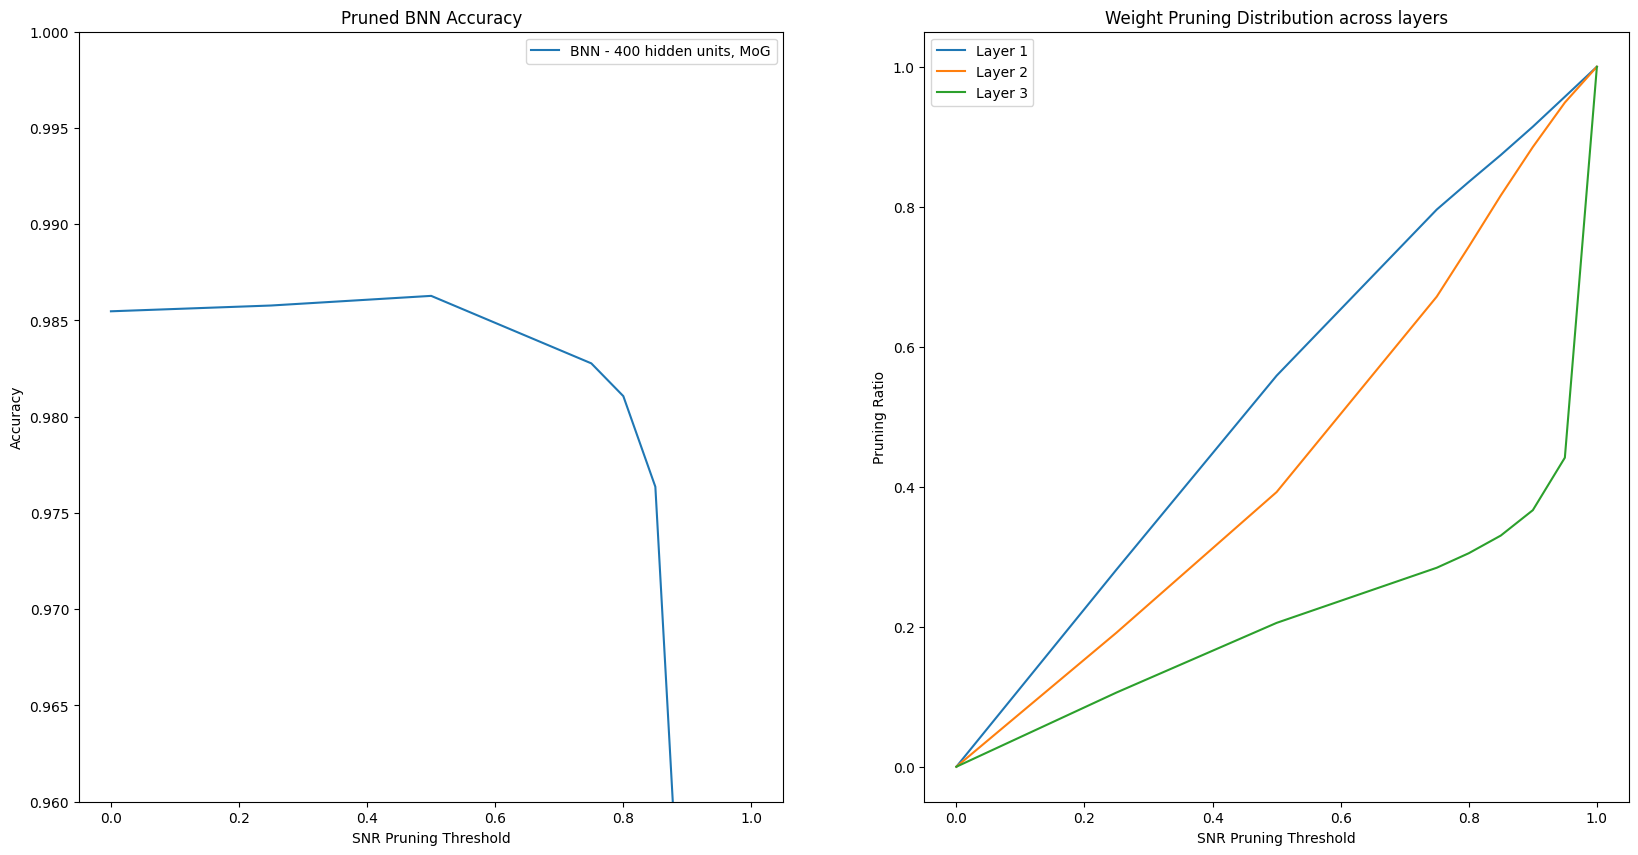

In [22]:
save_dir = "../plots/classification/"
for model in acc_dict.keys():
    if not model.__contains__("bnn"): continue
    description = MODEL_DETAILS_DICT[model].description
    accuracies = acc_dict[model]['accuracies']
    prune_ratios = acc_dict[model]['prune_ratios']

    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    ax = axes[0]
    ax1 = axes[1]

    sns.lineplot(y=[float(x.detach().numpy()) for x in accuracies], x=quantile_thresholds, label=f"{description}", ax=ax)
    # for layer in prune_ratios.keys():
    #     sns.lineplot(y=prune_ratios[layer], x=quantile_thresholds, label=f"Layer {layer[0]}", ax=ax1)

    # Formatting of plot
    ax.set_xlabel('SNR Pruning Threshold')
    ax.set(ylim=(0.96, 1.0))
    ax.set_ylabel('Accuracy')
    ax.set_title('Pruned BNN Accuracy')

    ax1.set_xlabel('SNR Pruning Threshold')
    ax1.set_ylabel('Pruning Ratio')
    ax1.set_title('Weight Pruning Distribution across layers')

    plt.show()

In [ ]:
plot_weight_samples(pruned_weight_samples)

In [22]:
net.evaluate(X_val)

tensor(0.9840)

In [20]:
eval_dict = evaluate_classifier(net, X_val)
eval_dict['eval_score']

tensor(0.9845)

## Analyse Multiple Models

### Evaluation

In [23]:
models = ['bnn_1200', 'dnn_do_1200', 'dnn_1200']
model_dict = {}

for model in models:
    
    MODEL_DETAILS = MODEL_DETAILS_DICT[model]
    
    # Load params
    with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device('cpu')))

    model_dict[model] = evaluate_classifier(net, X_val)
    print('{}: {}'.format(model, model_dict[model]['eval_score']))

2022-03-25 19:06:19,136 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:06:19,137 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:06:19,153 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:06:19,153 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:06:19,155 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:06:19,155 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


bnn_1200: 0.9849759340286255
dnn_do_1200: 0.9846754670143127
dnn_1200: 0.9830729365348816


In [24]:
# Create list of maximum confidence score for each guess
for model in models:
    dict = model_dict[model]

    for i in dict['probs']['incorrect']['all']:
        dict['probs']['incorrect']['max'].append(np.max(i))

    for i in dict['probs']['correct']['all']:
        dict['probs']['correct']['max'].append(np.max(i))

    model_dict[model]['probs']['max'] = np.array(model_dict[model]['probs']['max']).flatten()

Plot weight distribution 


2022-03-25 19:08:35,517 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:08:35,518 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:08:35,538 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:08:35,539 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:08:35,541 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:08:35,541 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


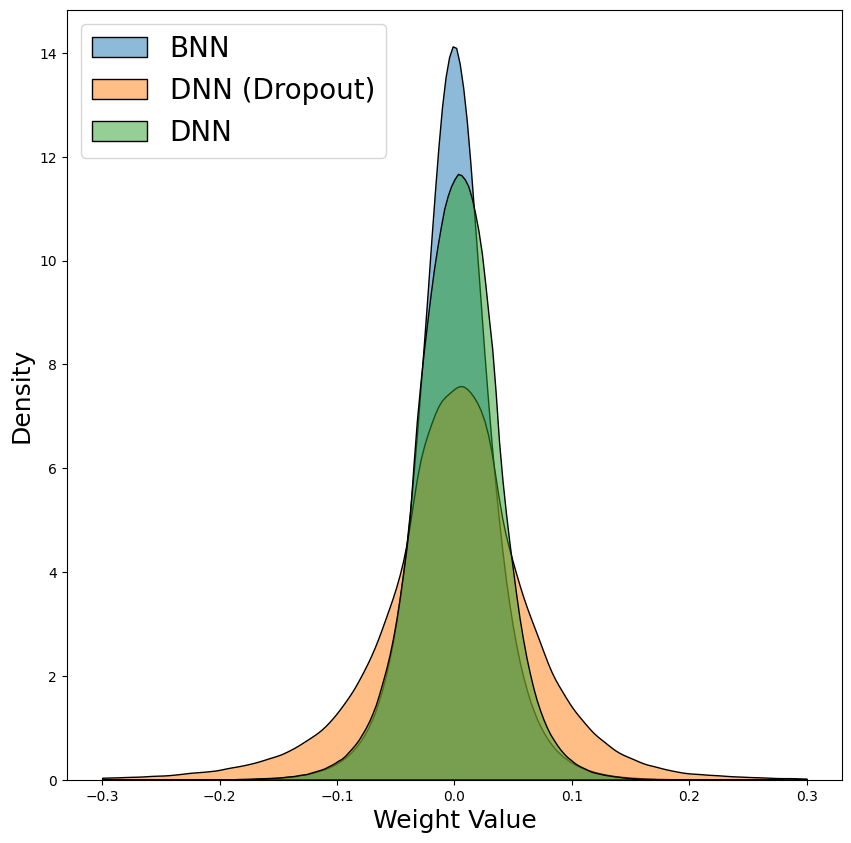

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# Formatting of plot
ax.set_xlabel('Weight Value', fontsize=18)
ax.set_ylabel('Density', fontsize=18)


for idx, model in enumerate(models):
    MODEL_DETAILS = MODEL_DETAILS_DICT[model]
    
    # Load params
    with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device('cpu')))

    weight_samples = net.weight_samples()

    comb_weight_samples = torch.hstack(weight_samples)
    sns.kdeplot(comb_weight_samples.flatten().detach().cpu().numpy(), fill=True, clip=[-0.3, 0.3], ax=ax, color=colors[idx], alpha=0.5, multiple="stack")
    # ax.hist(comb_weight_samples.flatten().detach().cpu().numpy(), **histogram_args)

    
# Display the plot
ax.legend(['BNN', 'DNN (Dropout)', 'DNN'], loc='upper left', prop={'size':20})
plt.savefig(os.path.join("../plots/classification/comb_weights_plot_1200.png"), pad_inches=0.2, bbox_inches='tight')
plt.show()

Plot reliability diagram

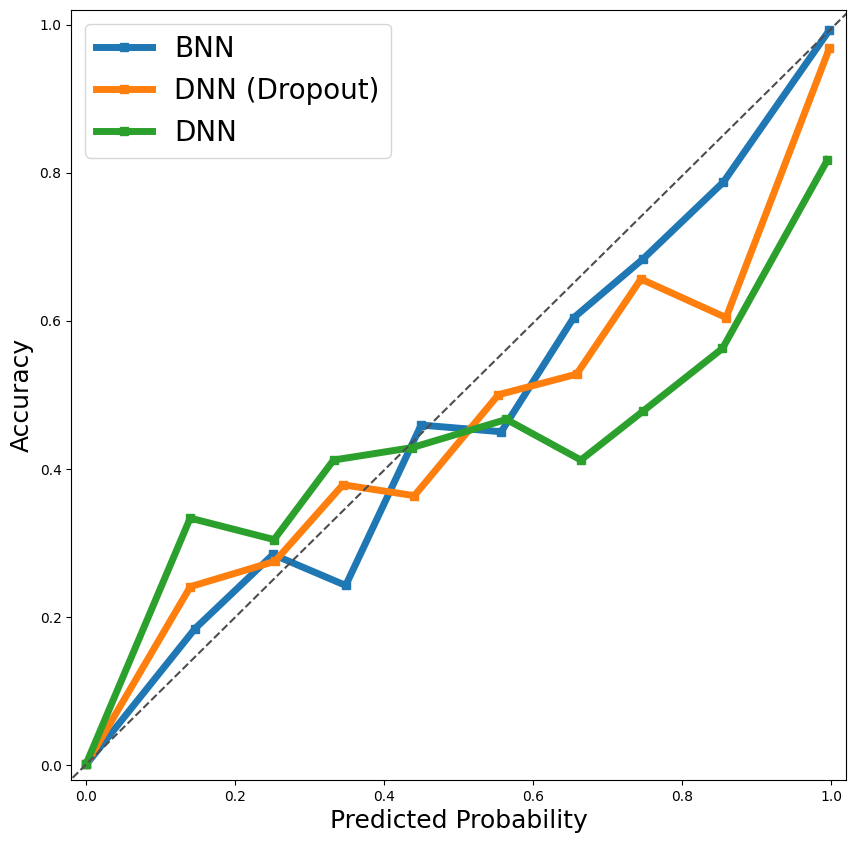

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for idx, model in enumerate(models):

    probs = model_dict[model]['probs']['all']
    conf = model_dict[model]['probs']['max']
    preds = model_dict[model]['preds']['all']
    labels = model_dict[model]['labels']
    
    bins = 10
    B = {}
    for i in range(bins+1):
        B[i] = [0,0,0]

    pred_prob = np.array(probs)
    for n in range(np.shape(preds)[0]):
        for d in range(np.max(labels)+1):
            whichBin = int(pred_prob[n][d]*bins)
            B[whichBin][0] += 1
            if d == labels[n]: B[whichBin][1] += 1
            B[whichBin][2] += pred_prob[n][d]

    correct = []
    predicted = []
    for i in range(bins):
        correct.append(B[i][1]/B[i][0])
        predicted.append(B[i][2]/B[i][0])


    ax.plot(predicted, correct, 's-', linewidth=5,
             label="{}".format(model), color=colors[idx])

ax.legend(['BNN', 'DNN (Dropout)', 'DNN'], loc='upper left', prop={'size':20})
ax.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
ax.set_xlim(-0.02,1.02)
ax.set_ylim(-0.02,1.02)
ax.set_xlabel("Predicted Probability", fontsize=18)
ax.set_ylabel("Accuracy", fontsize=18)
# ax.set_title("Reliability Diagram")

plt.savefig('../plots/classification/reliability_1200.png', bbox_inches='tight')
plt.show()

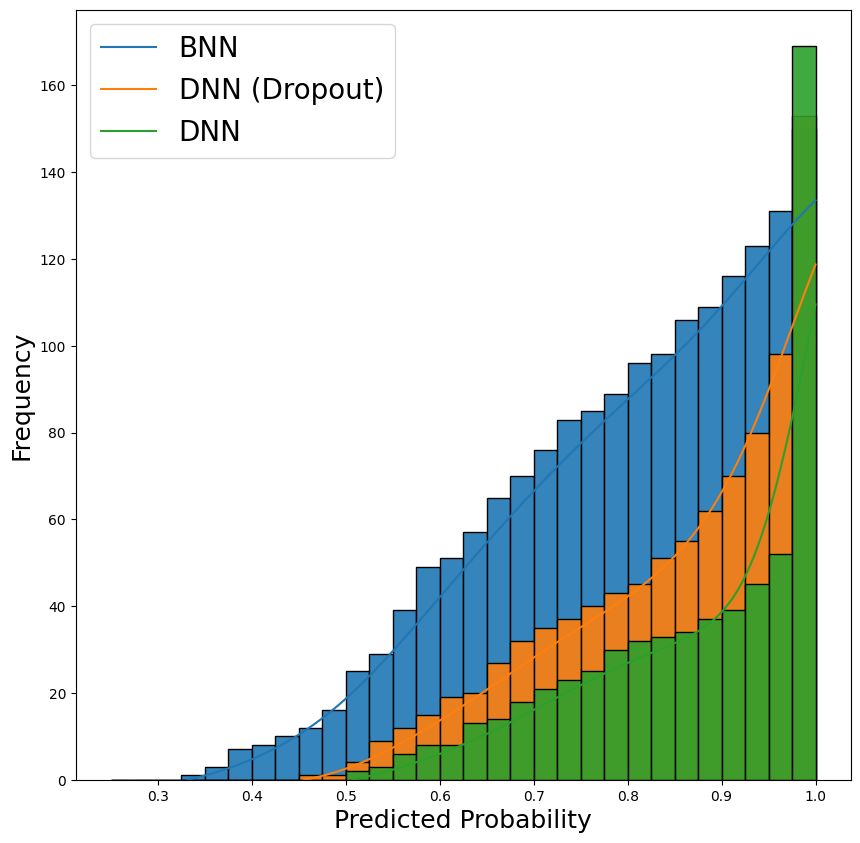

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, model in enumerate(models):
    dict = model_dict[model]

    ax = sns.histplot(ax=ax, data=dict['probs']['incorrect']['max'], bins=np.arange(0.25,1.025,0.025), label=model, alpha=0.9, kde=True, cumulative=True, color=sns.color_palette("tab10")[i])

    # ax.hist(dict['probs']['incorrect']['max'], bins=30, label=model, alpha=0.5)    
    # ax.hist(dict['probs']['correct']['max'], bins=10, label='Correct', alpha=0.5)

ax.legend(['BNN', 'DNN (Dropout)', 'DNN'], loc='upper left', prop={'size':20})
# ax.set_title("Confidence scores of incorrect predictions")
ax.set_xlabel("Predicted Probability", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)

plt.savefig('../plots/classification/incorrect_1200.png', bbox_inches='tight')
plt.show()

## Plot weight distribution for model

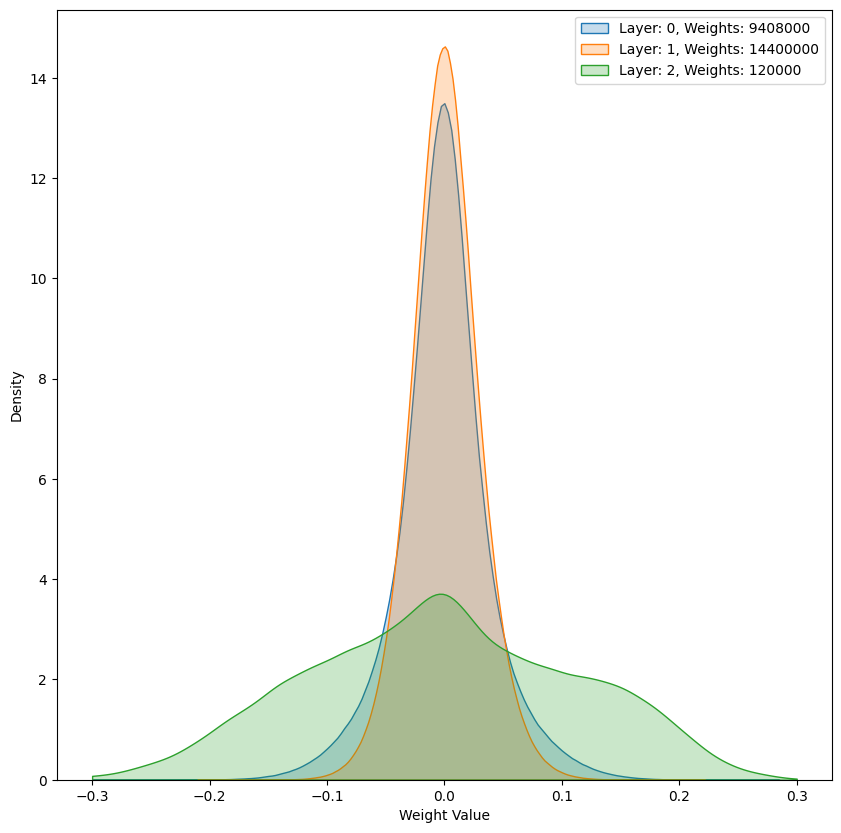

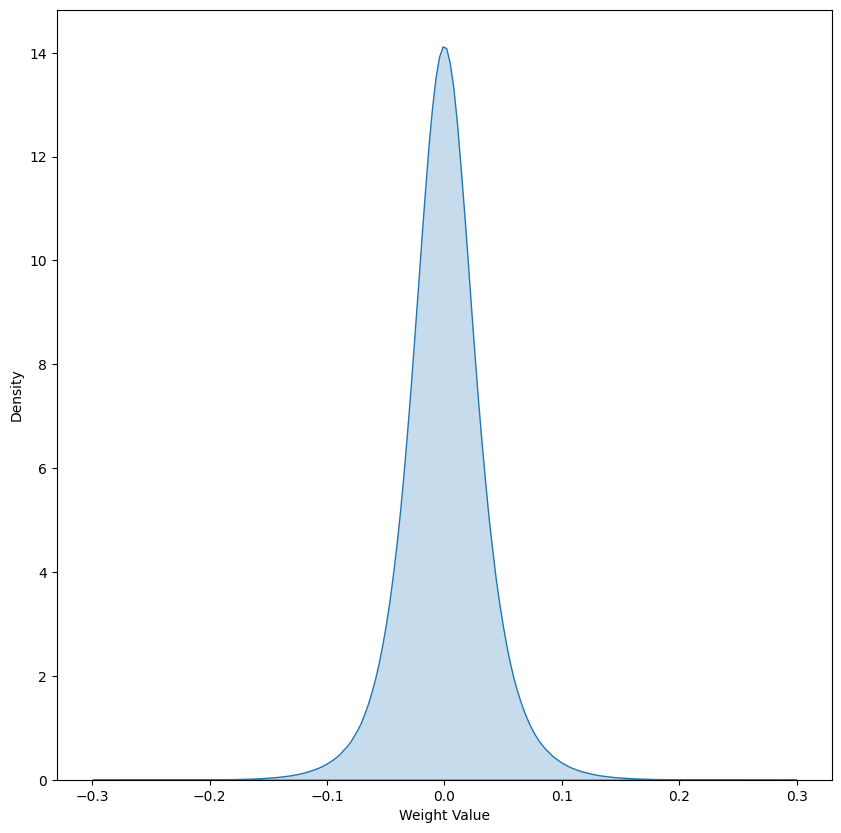

In [11]:
plot_weight_samples(net.weight_samples())

## Don't use the reliability diagram below

[0.         0.         0.         0.25       0.2777778  0.5
 0.49056605 0.6944444  0.7777778  0.9917292 ]
<class 'numpy.ndarray'>


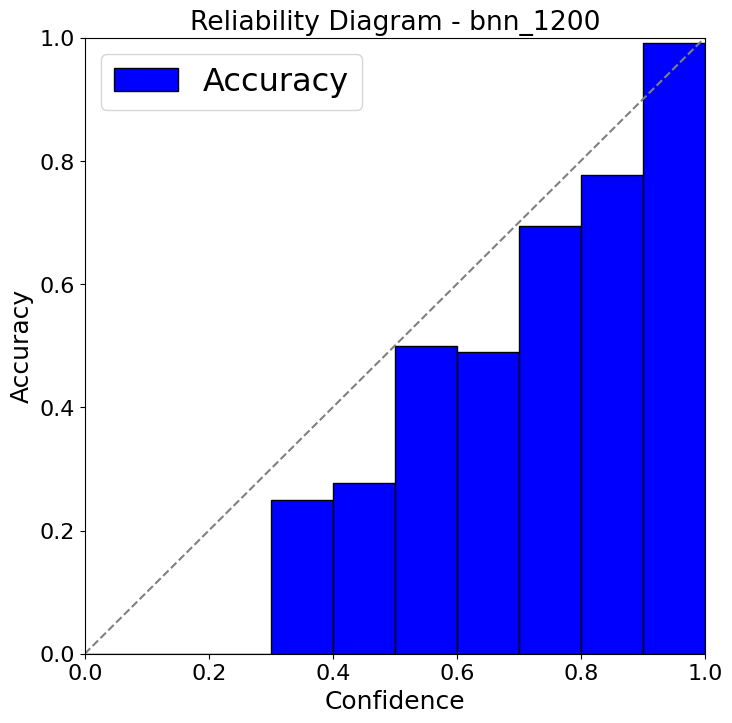

[0.         0.         0.         1.         0.         0.5
 0.5277778  0.65625    0.6041667  0.96813464]
<class 'numpy.ndarray'>


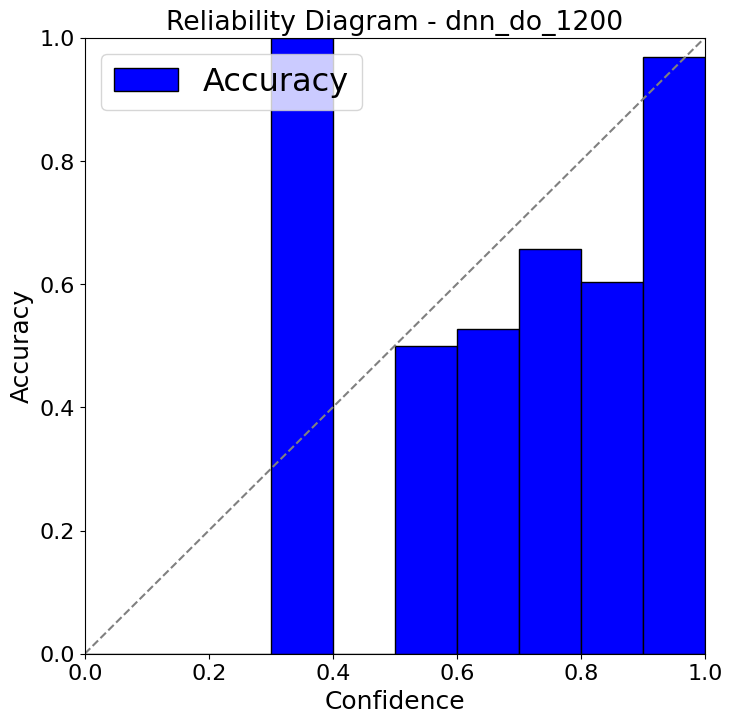

[0.         0.         0.         0.         0.         0.46666667
 0.4117647  0.47826087 0.5625     0.8171141 ]
<class 'numpy.ndarray'>


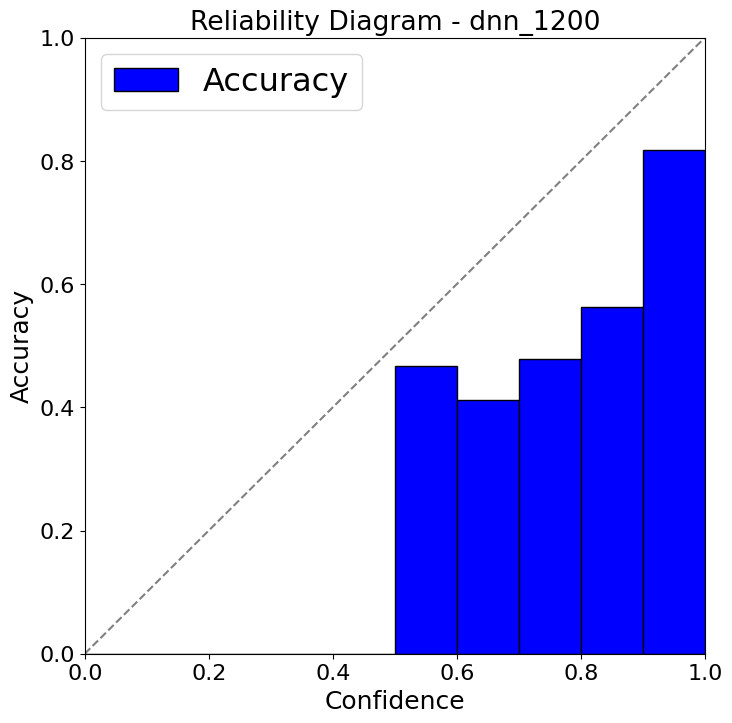

In [33]:
from ece_loss import make_model_diagrams

for model in models:

    probs = model_dict[model]['probs']['all']
    conf = model_dict[model]['probs']['max']
    preds = model_dict[model]['preds']['all']
    labels = model_dict[model]['labels']

    make_model_diagrams(probabilities=torch.from_numpy(np.array(probs)), predictions=torch.from_numpy(np.array(preds)), confidences=torch.from_numpy(np.array(conf)), labels=torch.from_numpy(np.array(labels)), model=model, n_bins=10)


# Histogram plots of incorrect/correct predictions

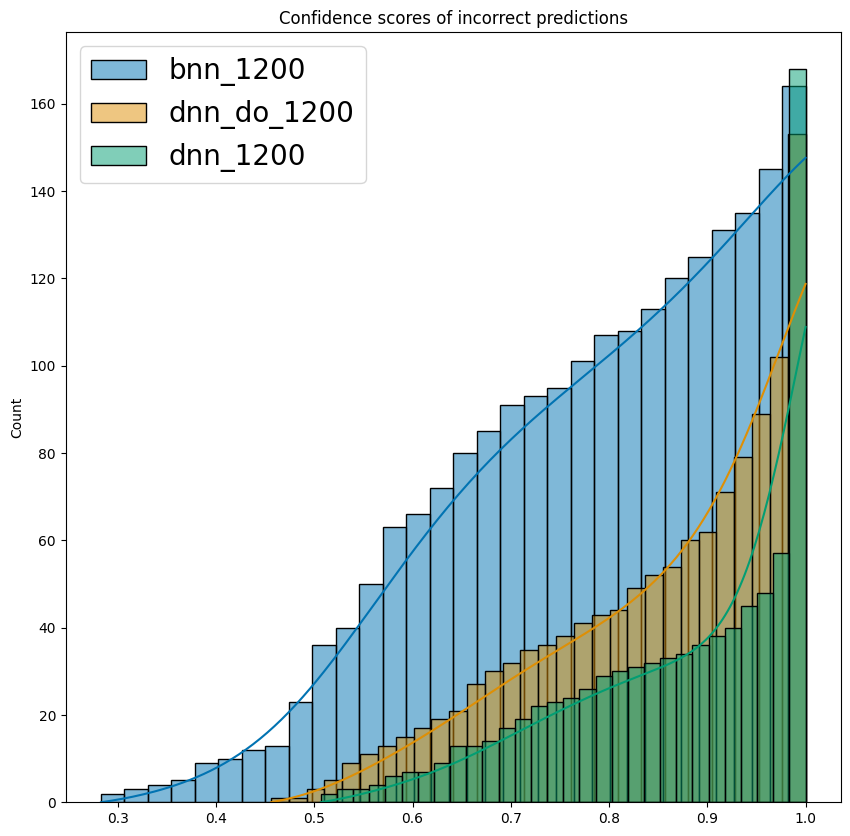

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, model in enumerate(models):
    dict = model_dict[model]

    ax = sns.histplot(ax=ax, data=dict['probs']['incorrect']['max'], bins=30, label=model, alpha=0.5, kde=True, cumulative=True, color=sns.color_palette("colorblind")[i])

    # ax.hist(dict['probs']['incorrect']['max'], bins=30, label=model, alpha=0.5)    
    # ax.hist(dict['probs']['correct']['max'], bins=10, label='Correct', alpha=0.5)

ax.legend(loc='upper left', prop={'size':20})
ax.set_title("Confidence scores of incorrect predictions")
plt.show()

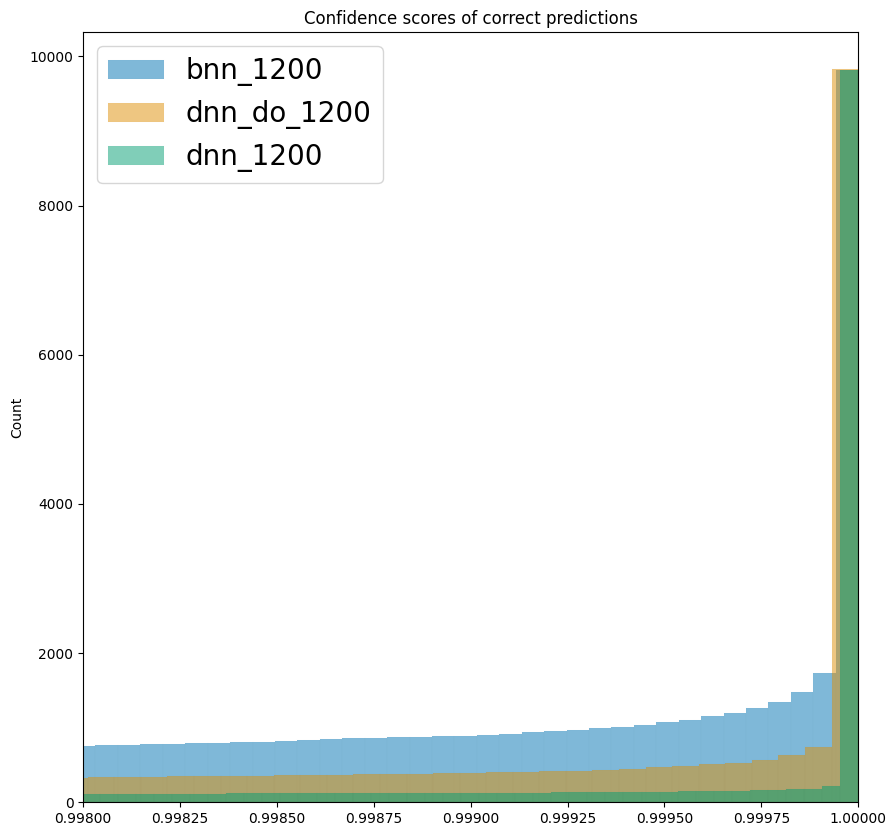

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, model in enumerate(models):
    dict = model_dict[model]

    ax = sns.histplot(ax=ax, data=dict['probs']['correct']['max'], bins=10000, label=model, alpha=0.5, kde=False, cumulative=True, color=sns.color_palette("colorblind")[i])

    # ax.hist(dict['probs']['incorrect']['max'], bins=30, label=model, alpha=0.5)    
    # ax.hist(dict['probs']['correct']['max'], bins=10, label='Correct', alpha=0.5)

ax.legend(loc='upper left', prop={'size':20})
ax.set_xlim([0.998, 1.0])
ax.set_title("Confidence scores of correct predictions")
plt.show()

## Recorded Metrics

In [19]:
eval_metric = np.load(os.path.join(MODEL_DETAILS.dir, 'eval_metric.npy'))
print(eval_metric[-1])

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(eval_metric)

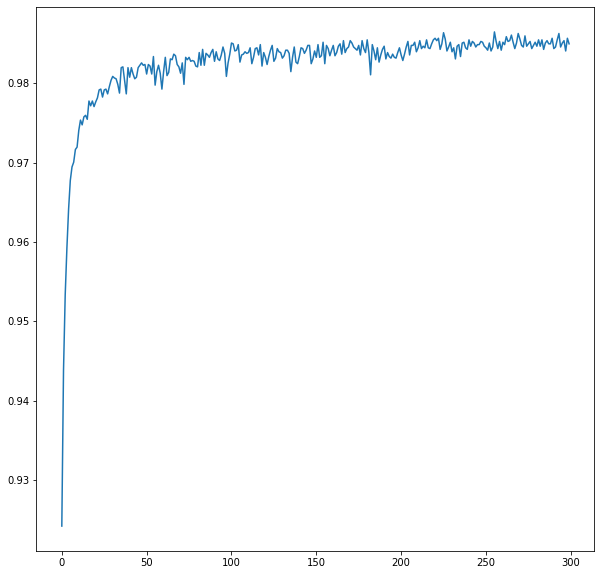

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(eval_metric)

In [ ]:
loss = np.load(os.path.join(MODEL_DETAILS.dir, 'loss.npy'))

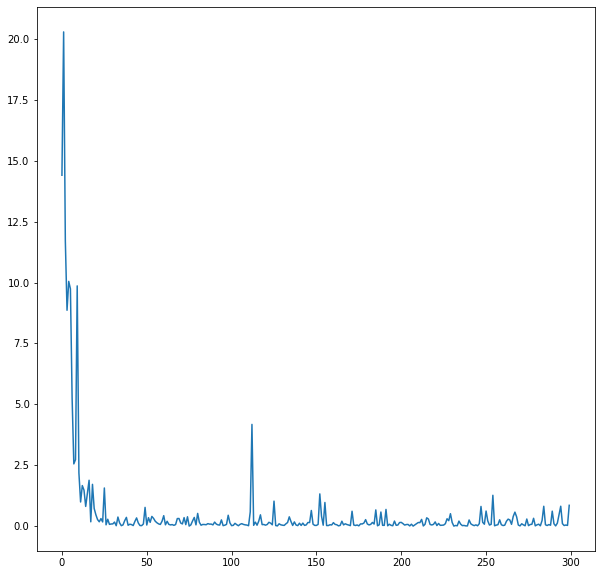

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(loss)